In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d vuppalaadithyasairam/bone-fracture-detection-using-xrays

bone-fracture-detection-using-xrays.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/bone-fracture-detection-using-xrays.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import os
dataset_path='/content/archive (6)'
dataset_contents=os.listdir(dataset_path)
print(dataset_contents)

['val', 'train']


In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
#generators
train_ds=keras.utils.image_dataset_from_directory(
    directory='/content/archive (6)/train',
    labels='inferred',
    label_mode='int',# fractured =0, not fractured=1
    batch_size=20,
    image_size=(256,256)
)


validation_ds=keras.utils.image_dataset_from_directory(
    directory='/content/archive (6)/val',
    labels='inferred',
    label_mode='int',# fractured =0, not fractured=1
    batch_size=20,
    image_size=(256,256)
)

Found 8863 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


In [7]:
#Normalize
#we store images in the form of numpy and numpy stores values between 0 and 255 to store value
#  in between 0 and 1 pixels values we doing the following function
def process(image,label):
  image=tf.cast(image/255. ,tf.float32)# divide the image by 255 and return it
  return image,label

train_ds=train_ds.map(process)
validation_ds=validation_ds.map(process)

In [8]:
import tensorflow
# create CNN Model
model=Sequential()
# filters = 32
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',input_shape=(256,256,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

# filters = 64
model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

# filters = 128
model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(64,activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.02)))# 128 neurons
model.add(Dropout(0.2))
#model.add(Dense(256,activation='relu'))# 128 neurons
#model.add(Dropout(0.2))
model.add(Dense(32,activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.02)))# 64 neurons
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))#output

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [10]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.02)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
callback=EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=10,
    verbose=0,
    mode="auto",
    restore_best_weights=True
)

In [12]:
history=model.fit(train_ds,epochs=100,validation_data=validation_ds,callbacks=callback)

Epoch 1/100
444/444 [==============================] - 39s 58ms/step - loss: 3.2858 - accuracy: 0.5837 - val_loss: 1.4845 - val_accuracy: 0.5200
Epoch 2/100
444/444 [==============================] - 26s 57ms/step - loss: 1.4175 - accuracy: 0.6341 - val_loss: 1.4395 - val_accuracy: 0.5400
Epoch 3/100
444/444 [==============================] - 25s 56ms/step - loss: 1.1431 - accuracy: 0.6908 - val_loss: 1.0309 - val_accuracy: 0.6517
Epoch 4/100
444/444 [==============================] - 26s 58ms/step - loss: 1.0908 - accuracy: 0.7428 - val_loss: 1.1422 - val_accuracy: 0.6650
Epoch 5/100
444/444 [==============================] - 25s 56ms/step - loss: 1.0501 - accuracy: 0.7623 - val_loss: 1.2142 - val_accuracy: 0.6217
Epoch 6/100
444/444 [==============================] - 26s 59ms/step - loss: 0.9827 - accuracy: 0.8169 - val_loss: 1.1444 - val_accuracy: 0.7833
Epoch 7/100
444/444 [==============================] - 25s 55ms/step - loss: 0.9795 - accuracy: 0.8577 - val_loss: 1.4306 - val_ac

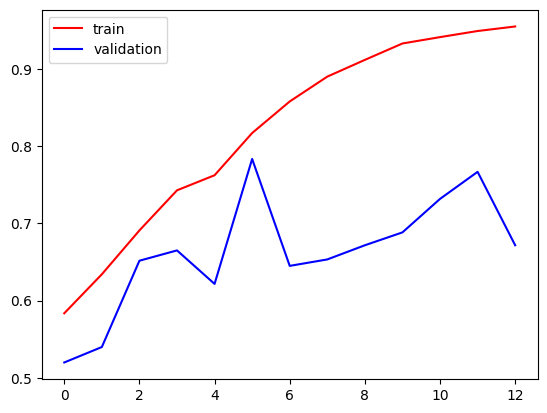

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

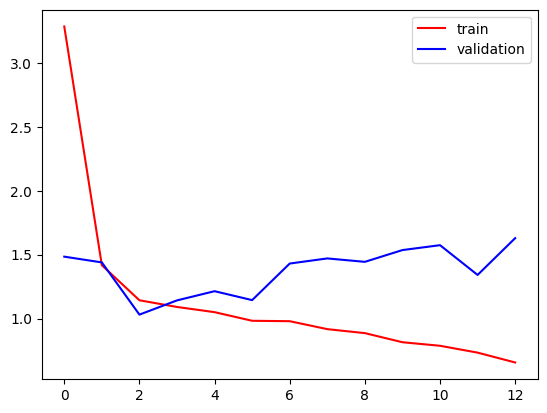

In [14]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [15]:
import cv2
test_img = cv2.imread('/content/archive (6)/train/not fractured/13-rotated1-rotated1-rotated2-rotated1.jpg')

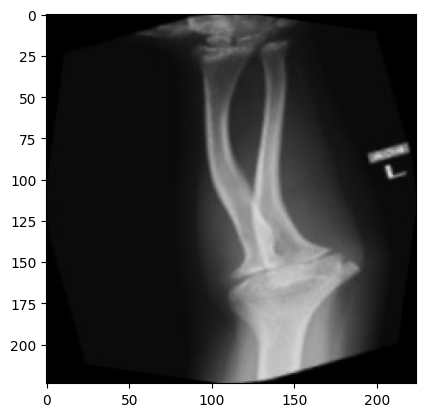

In [16]:
plt.imshow(test_img)

In [17]:
test_img.shape

(224, 224, 3)

In [18]:
test_img=cv2.resize(test_img,(256,256))

In [19]:
test_input = test_img.reshape((1,256,256,3))

In [20]:
ans=model.predict(test_input)

1/1 [==============================] - 0s 211ms/step


In [21]:
if ans==0:
  print("This is Fractured")
else:
  print("This is not Fractured")

This is not Fractured


In [22]:
ans

array([[3.1936528e-26]], dtype=float32)

In [23]:
model.save('bone_fracture_model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
